# Report based on EPI run at single slice position

In [1]:
from __future__ import division, print_function

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('seaborn')
import numpy as np

from mriqa.phantoms import SIEMENSLONGBOTTLE, phantom_mask_2d
from mriqa.dcmio import fetch_series, coil_elements
from mriqa.tools import show_montage
from mriqa.reports import ghosting_report

from fmriqa import fmriqa


In [2]:
patid = 'PQACRK20161201'
studyid = '1'
series = {
    'Stability': [8]
}

In [3]:
dobjs = sorted(
    fetch_series(patid, studyid, sernos=series['Stability']),
    key=lambda x: (float(x.SliceLocation), float(x.AcquisitionTime))
)
assert len(set([d.SliceLocation for d in dobjs])) == 1
print(len(set([d.AcquisitionTime for d in dobjs])))

250


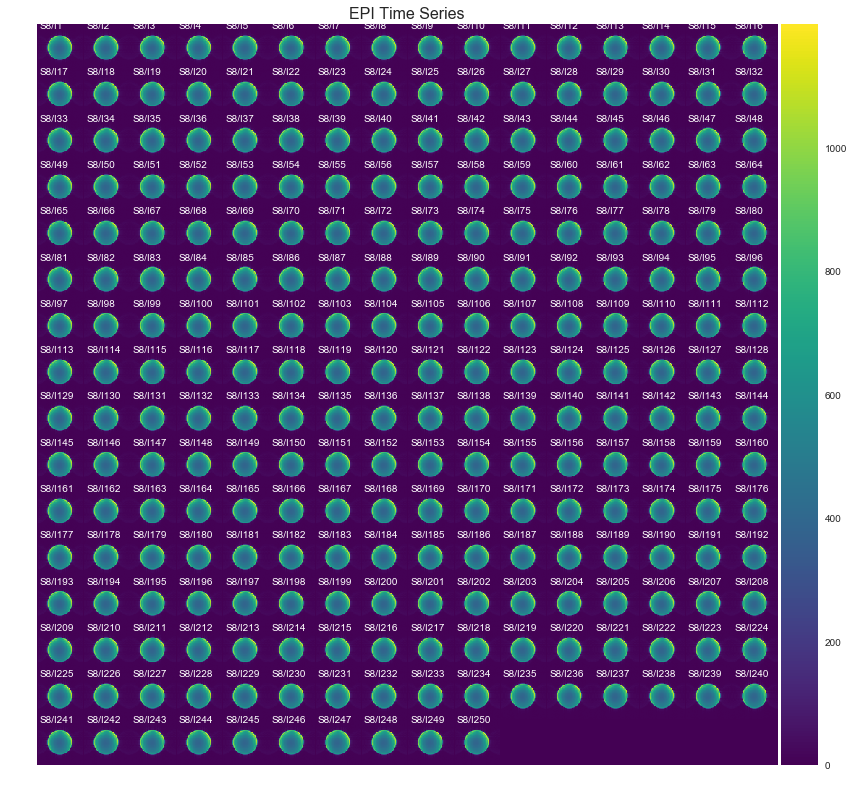

In [4]:
show_montage(dobjs, cmap='viridis', title='EPI Time Series');

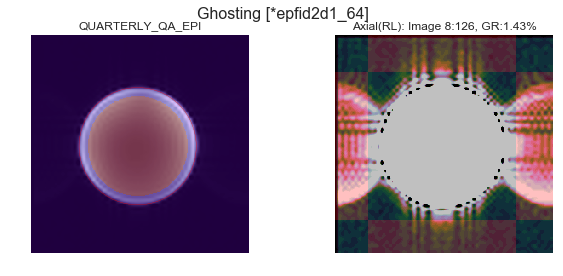

Series                         8
Frames                         1
TR                           500
TE                            22
Matrix                  (64, 64)
Sequence            *epfid2d1_64
FoV               (250.0, 250.0)
Bandwidth                   3550
PhaseAxis                    ROW
PhaseDirection                RL
Protocol        QUARTERLY_QA_EPI
Orientation                Axial
Phantom                   549.88
Left                     13.3286
Right                    13.8287
Top                      5.77733
Bottom                   5.64236
GhostRatio                 1.431

In [5]:
# LONGBOTTLE: Ghosting
raw_tra = fetch_series(patid, studyid, sernos=series['Stability'])
results = ghosting_report([raw_tra[len(raw_tra)//2]], phantom=SIEMENSLONGBOTTLE)
results.T

In [6]:
def simple_time_series(dobjs):
    '''
    Read an fmri time series in simple single slcie form from specified files.
    Each file is expected to be one time point
    Returns a rank 3 numpy array organized nt,ny,nx

    Parameters
    ----------
    dobj: list of dicom objects
    '''

    # Pixel and slice spacing in mm
    dx, dy = dobjs[0].PixelSpacing

    # Temporal spacing in seconds
    acq_times = [float(d.AcquisitionTime) for d in dobjs]
    dt = acq_times[1] - acq_times[0]

    stack = np.asarray([d.pixel_array for d in dobjs], dtype=float)

    # Return as a 3d numpy array (t, y, x)
    return stack, (dx, dy, dt)

time_series, (dx, dy, dt) = simple_time_series(dobjs)
nt, ny, nx = time_series.shape

In [7]:
def centre_of_mass(series):
    ''' Centre of mass [(x,y), (x,y)..] as a fn. of time.

        Parameters
        ----------
        volume_series: Numpy rank-3 volume time series

        Returns
        -------
        List of (x,y) tuples
    '''
    nt, ny, nx = series.shape

    # Weighting ramps for x and y moments
    xramp, yramp = np.meshgrid(list(range(nx)), list(range(ny)))

    # Normalisation by total intensity
    norms = series.sum(axis=(1, 2))

    # List of (x, y) tuples
    return [
        ((xramp * series[t]).sum() / norms[t],
         (yramp * series[t]).sum() / norms[t])
        for t in range(nt)
    ]

#### TODO
- better names for images

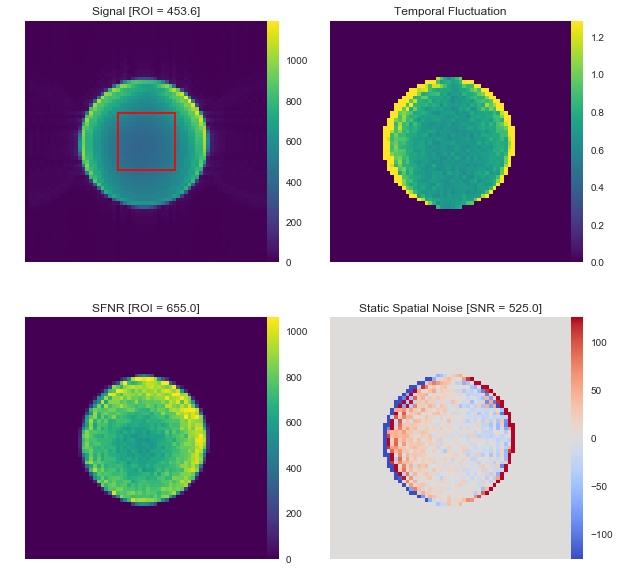

In [8]:
roisize = 15
roicolour = 'red'

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flat

# Average Image
signal = fmriqa.signal_image(time_series)
im = axs[0].imshow(fmriqa.signal_image(time_series), cmap='viridis')
axs[0].axis('off')
axs[0].set_title('Signal [ROI = %0.1f]' % fmriqa.signal_summary(time_series, roisize=roisize))

# colourbar clipped to height of image
divider = make_axes_locatable(axs[0])
fig.colorbar(im, cax=divider.append_axes("right", size="5%"))

# Show the region of interest to be used
x1, x2, y1, y2 = int(nx/2 - roisize/2), int(nx/2 + roisize/2), int(ny/2 - roisize/2), int(ny/2 + roisize/2)
axs[0].axhline(y=y1, xmin=(x1+0.5)/nx,    xmax=(x2+0.5)/nx,    color=roicolour)
axs[0].axvline(x=x1, ymin=(ny-y1-0.5)/ny, ymax=(ny-y2-0.5)/ny, color=roicolour)
axs[0].axhline(y=y2, xmin=(x1+0.5)/nx,    xmax=(x2+0.5)/nx,    color=roicolour)
axs[0].axvline(x=x2, ymin=(ny-y1-0.5)/ny, ymax=(ny-y2-0.5)/ny, color=roicolour)

# Mask to help set display window 
mask = phantom_mask_2d(signal, mode='erode')

# Image of temporal fluctuations
tnf = fmriqa.temporalnoise_fluct_image(time_series)
im = axs[1].imshow(tnf, vmax=np.max(tnf * mask), cmap='viridis')
axs[1].axis('off')
axs[1].set_title('Temporal Fluctuation')
divider = make_axes_locatable(axs[1])
fig.colorbar(im, cax=divider.append_axes("right", size="5%"))

# Image of normalised temporal fluctuations
sfnri = fmriqa.sfnr_image(time_series)
vmax = np.max(sfnri * mask)
im = axs[2].imshow(sfnri, vmax=np.max(sfnri * mask), cmap='viridis')
axs[2].axis('off')
axs[2].set_title('SFNR [ROI = %0.1f]' % fmriqa.sfnr_summary(time_series, roisize=roisize))
divider = make_axes_locatable(axs[2])
fig.colorbar(im, cax=divider.append_axes("right", size="5%"))

# Image of average spatial noise
ssn = fmriqa.static_spatial_noise_image(time_series)
vmax = np.max(abs(ssn * mask))
im = axs[3].imshow(ssn, vmin=-vmax, vmax=vmax, cmap='coolwarm')
axs[3].axis('off')
axs[3].set_title('Static Spatial Noise [SNR = %0.1f]' % fmriqa.snr_summary(time_series, roisize=roisize))
divider = make_axes_locatable(axs[3])
fig.colorbar(im, cax=divider.append_axes("right", size="5%"));

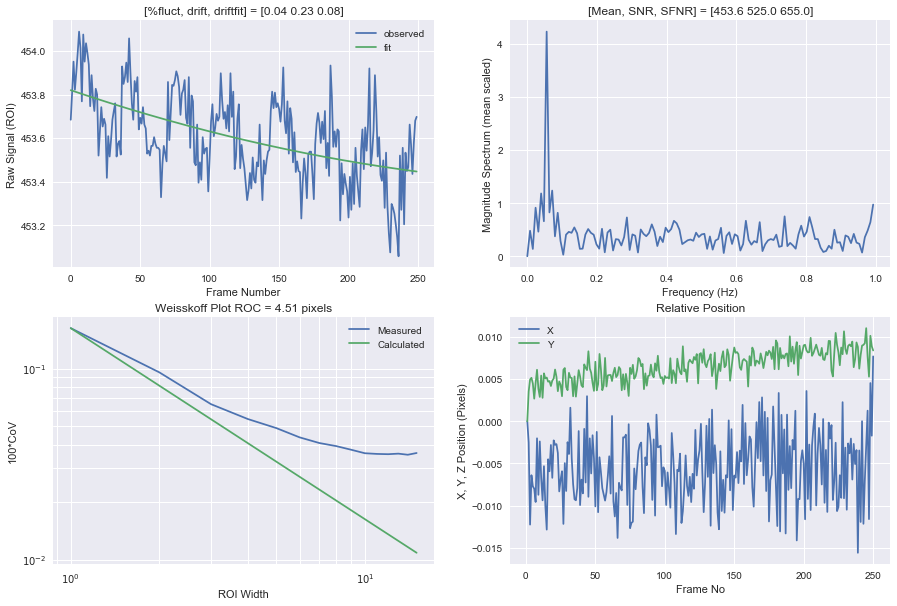

In [9]:
# Time course of gain fluctuations in an ROI
time_course = fmriqa.roi_means_time_course(time_series, roisize=roisize)
nt = len(time_course)
(a, b, c) = np.polyfit(range(nt), time_course, deg=2)
trend = np.polyval((a, b, c), range(nt))

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flat

axs[0].plot(np.arange(nt), time_course, '+-', label='observed')
axs[0].plot(np.arange(nt), trend, '-', label='fit')
sd, fluct, drift_raw, drift_fit = fmriqa.fluctuation_and_drift(time_series, roisize=roisize)
summary_vals = (fluct, drift_raw, drift_fit)
axs[0].set_title('[%%fluct, drift, driftfit] = [%.2f %.2f %.2f]' % summary_vals)
axs[0].set_xlabel('Frame Number')
axs[0].set_ylabel('Raw Signal (ROI)')
axs[0].grid(True)
axs[0].legend()


# Magnitude spectrum of temporal fluctuations in an ROI
spectrum = fmriqa.magnitude_spectrum(time_series, roisize=roisize)
nf = len(spectrum)
frequencies = np.linspace(0, (nf-1.0)/dt/nf/2.0, num=nf)
df = 1/dt

axs[1].plot(frequencies, spectrum, '-')
summary_vals = (
    fmriqa.signal_summary(time_series, roisize=roisize),
    fmriqa.snr_summary(time_series, roisize=roisize),
    fmriqa.sfnr_summary(time_series, roisize=roisize)
)

axs[1].set_title('[Mean, SNR, SFNR] = [%.1f %.1f %.1f]' % summary_vals)
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Magnitude Spectrum (mean scaled)')
axs[1].grid(True)


# Weisskoff plot of fluctuation noise as a function of ROI size
roc, covs = fmriqa.weisskoff(time_series, max_roisize=roisize)

axs[2].loglog(range(1, len(covs)+1), 100*covs, '+-', label='Measured')
axs[2].loglog(range(1, len(covs)+1),
             100*covs[0] / np.arange(1, len(covs)+1),
             '-', label = 'Calculated')
axs[2].set_title('Weisskoff Plot ROC = %.2f pixels' % roc)
axs[2].set_xlabel('ROI Width')
axs[2].set_ylabel('100*CoV')
axs[2].grid(True, 'both')
axs[2].legend()


# Movement of the phantom Centre of Gravity from its starting position
cofg = centre_of_mass(time_series)
axs[3].plot(range(1, len(cofg)+1),
           [x-cofg[0][0] for (x,y) in cofg], '-', label='X')
axs[3].plot(range(1, len(cofg)+1),
           [y-cofg[0][1] for (x,y) in cofg], '-', label='Y')
axs[3].set_title('Relative Position')
axs[3].set_xlabel('Frame No')
axs[3].set_ylabel('X, Y, Z Position (Pixels)')
axs[3].grid(True)
axs[3].legend();